In [1]:
import torch
from torch import nn, optim

import monai
import numpy as np
import nibabel as nib
from glob import glob
from matplotlib import pyplot as plt
import copy

from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized
)

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch


from torch.utils.tensorboard import SummaryWriter

import sklearn

In [2]:
def average_weights(local_trained_weights):
    """Returns the average of the weights.
       local_trained_weights: The list of tensors (of the same shape) that will be averaged
    """
    # Initialize copy model weights with the untrained model weights.
    avg_weights = copy.deepcopy(local_trained_weights[0])
    for key in avg_weights.keys():
        for i in range(1, len(local_trained_weights)):
            avg_weights[key] += local_trained_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(local_trained_weights))
    return avg_weights


In [3]:
#loading volume paths
LOCATION = 'scan' #laptop
if LOCATION == 'scan':
    isles_data_root = '/str/data/ASAP/miccai22_data/isles/federated/'
    exp_root = '/home/otarola/miccai22/fedem/'

if LOCATION == 'laptop':
    isles_data_root = '/data/ASAP/miccai22_data/isles/federated/'

center1_cbf_paths_train  = sorted(glob(isles_data_root+'center1/train/'+'/**/*CBF*/*.nii'))
center1_cbf_paths_valid  = sorted(glob(isles_data_root+'center1/valid/'+'/**/*CBF*/*.nii'))
center1_cbf_paths_test   = sorted(glob(isles_data_root+'center1/test/'+'/**/*CBF*/*.nii'))
center1_lbl_paths_train  = sorted(glob(isles_data_root+'center1/train/'+'/**/*OT*/*nii'))
center1_lbl_paths_valid  = sorted(glob(isles_data_root+'center1/valid/'+'/**/*OT*/*nii'))
center1_lbl_paths_test  = sorted(glob(isles_data_root+'center1/test/'+'/**/*OT*/*nii'))

center2_cbf_paths_train  = sorted(glob(isles_data_root+'center2/train/'+'/**/*CBF*/*.nii'))
center2_cbf_paths_valid  = sorted(glob(isles_data_root+'center2/valid/'+'/**/*CBF*/*.nii'))
center2_cbf_paths_test   = sorted(glob(isles_data_root+'center2/test/'+'/**/*CBF*/*.nii'))
center2_lbl_paths_train  = sorted(glob(isles_data_root+'center2/train/'+'/**/*OT*/*nii'))
center2_lbl_paths_valid  = sorted(glob(isles_data_root+'center2/valid/'+'/**/*OT*/*nii'))
center2_lbl_paths_test   = sorted(glob(isles_data_root+'center2/test/'+'/**/*OT*/*nii'))

center3_cbf_paths_train  = sorted(glob(isles_data_root+'center3/train/'+'/**/*CBF*/*.nii'))
center3_cbf_paths_valid  = sorted(glob(isles_data_root+'center3/valid/'+'/**/*CBF*/*.nii'))
center3_cbf_paths_test   = sorted(glob(isles_data_root+'center3/test/'+'/**/*CBF*/*.nii'))
center3_lbl_paths_train  = sorted(glob(isles_data_root+'center3/train/'+'/**/*OT*/*nii'))
center3_lbl_paths_valid  = sorted(glob(isles_data_root+'center3/valid/'+'/**/*OT*/*nii'))
center3_lbl_paths_test   = sorted(glob(isles_data_root+'center3/test/'+'/**/*OT*/*nii'))

center4_cbf_paths_train  = sorted(glob(isles_data_root+'center4/train/'+'/**/*CBF*/*.nii'))
center4_cbf_paths_valid  = sorted(glob(isles_data_root+'center4/valid/'+'/**/*CBF*/*.nii'))
center4_cbf_paths_test   = sorted(glob(isles_data_root+'center4/test/'+'/**/*CBF*/*.nii'))
center4_lbl_paths_train  = sorted(glob(isles_data_root+'center4/train/'+'/**/*OT*/*nii'))
center4_lbl_paths_valid  = sorted(glob(isles_data_root+'center4/valid/'+'/**/*OT*/*nii'))
center4_lbl_paths_test   = sorted(glob(isles_data_root+'center4/test/'+'/**/*OT*/*nii'))
print("===============CENTER1====================")
print(len(center1_cbf_paths_train),len(center1_lbl_paths_train))
print(len(center1_cbf_paths_valid), len(center1_lbl_paths_valid))
print(len(center1_cbf_paths_test),  len(center1_lbl_paths_test))
print("===============CENTER2====================")
print(len(center2_cbf_paths_train),len(center2_lbl_paths_train))
print(len(center2_cbf_paths_valid), len(center2_lbl_paths_valid))
print(len(center2_cbf_paths_test),  len(center2_lbl_paths_test))
print("===============CENTER3====================")
print(len(center3_cbf_paths_train),len(center3_lbl_paths_train))
print(len(center3_cbf_paths_valid), len(center3_lbl_paths_valid))
print(len(center3_cbf_paths_test),  len(center3_lbl_paths_test))
print("===============CENTER4====================")
print(len(center4_cbf_paths_train),len(center4_lbl_paths_train))
print(len(center4_cbf_paths_valid), len(center4_lbl_paths_valid))
print(len(center4_cbf_paths_test),  len(center4_lbl_paths_test))


===============CENTER1====================
15 15
3 3
4 4
===============CENTER2====================
41 41
8 8
8 8
===============CENTER3====================
1 1
0 0
1 1
===============CENTER4====================
9 9
2 2
2 2


In [4]:
imtrans = Compose(
    [   LoadImage(image_only=True),
        #RandScaleIntensity( factors=0.1, prob=0.5),
        ScaleIntensity(minv=0.0, maxv=1200),
        AddChannel(),
        RandRotate90( prob=0.5, spatial_axes=[0, 1]),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandRotate90( prob=0.5, spatial_axes=[0, 1]),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

In [5]:
imtrans_test = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(minv=0.0, maxv=1200),
        AddChannel(),
        #RandSpatialCrop((224, 224,1), random_size=False), In test we would like to process ALL slices
        EnsureType(),
        #Resized
    ]
)

segtrans_test = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        #RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

In [6]:
batch_size = 2

In [7]:
##################C1
c1_ds_train = ArrayDataset(center1_cbf_paths_train, imtrans, center1_lbl_paths_train, segtrans)
c1_train_loader   = torch.utils.data.DataLoader(
    c1_ds_train, batch_size=batch_size, num_workers=1, pin_memory=torch.cuda.is_available()
)

c1_ds_valid = ArrayDataset(center1_cbf_paths_valid, imtrans, center1_lbl_paths_valid, segtrans)
c1_valid_loader   = torch.utils.data.DataLoader(
    c1_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c1_ds_test = ArrayDataset(center1_cbf_paths_test, imtrans_test, center1_lbl_paths_test, segtrans_test)
c1_test_loader   = torch.utils.data.DataLoader(
    c1_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)


##################C2
c2_ds_train = ArrayDataset(center2_cbf_paths_train, imtrans, center2_lbl_paths_train, segtrans)
c2_train_loader   = torch.utils.data.DataLoader(
    c2_ds_train, batch_size=batch_size, num_workers=1, pin_memory=torch.cuda.is_available()
)

c2_ds_valid = ArrayDataset(center2_cbf_paths_valid, imtrans, center2_lbl_paths_valid, segtrans)
c2_valid_loader   = torch.utils.data.DataLoader(
    c2_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c2_ds_test = ArrayDataset(center2_cbf_paths_test, imtrans_test, center2_lbl_paths_test, segtrans_test)
c2_test_loader   = torch.utils.data.DataLoader(
    c2_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

##################C3
c3_ds_train = ArrayDataset(center3_cbf_paths_train, imtrans, center3_lbl_paths_train, segtrans)
c3_train_loader   = torch.utils.data.DataLoader(
    c3_ds_train, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c3_ds_valid = ArrayDataset(center3_cbf_paths_valid, imtrans, center3_lbl_paths_valid, segtrans)
c3_valid_loader   = torch.utils.data.DataLoader(
    c3_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c3_ds_test = ArrayDataset(center3_cbf_paths_test, imtrans_test, center3_lbl_paths_test, segtrans_test)
c3_test_loader   = torch.utils.data.DataLoader(
    c3_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

##################C4
c4_ds_train = ArrayDataset(center4_cbf_paths_train, imtrans, center4_lbl_paths_train, segtrans)
c4_train_loader   = torch.utils.data.DataLoader(
    c4_ds_train, batch_size=batch_size, num_workers=1, pin_memory=torch.cuda.is_available()
)

c4_ds_valid = ArrayDataset(center4_cbf_paths_valid, imtrans, center4_lbl_paths_valid, segtrans)
c4_valid_loader   = torch.utils.data.DataLoader(
    c4_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

c4_ds_test = ArrayDataset(center4_cbf_paths_test, imtrans_test, center4_lbl_paths_test, segtrans_test)
c4_test_loader   = torch.utils.data.DataLoader(
    c4_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)


im, seg = first(c1_train_loader)
print(im.shape, seg.shape)
print(np.histogram(seg[0,0,:,:,0]))
print(im.max())



all_ds_valid = ArrayDataset(center1_cbf_paths_valid+center2_cbf_paths_valid+center3_cbf_paths_valid+center4_cbf_paths_valid,
                            imtrans, center1_lbl_paths_valid+center2_lbl_paths_valid+center3_lbl_paths_valid+center4_lbl_paths_valid,
                            segtrans)
all_valid_loader   = torch.utils.data.DataLoader(
    all_ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

all_ds_test = ArrayDataset(center1_cbf_paths_test+center2_cbf_paths_test+center3_cbf_paths_test+center4_cbf_paths_test,
                            imtrans, center1_lbl_paths_test+center2_lbl_paths_test+center3_lbl_paths_test+center4_lbl_paths_test,
                            segtrans)
all_test_loader   = torch.utils.data.DataLoader(
    all_ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)



torch.Size([2, 1, 224, 224, 1]) torch.Size([2, 1, 224, 224, 1])
(array([    0,     0,     0,     0,     0, 50176,     0,     0,     0,
           0]), array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
      dtype=float32))
tensor(1200.)


In [8]:
im, seg = first(c2_train_loader)


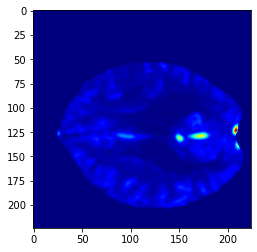

In [9]:
plt.imshow(im[0,0,:,:,0],cmap='jet')

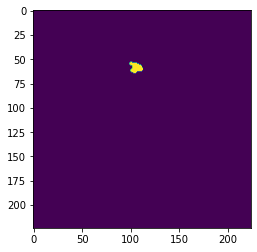

In [10]:
plt.imshow(seg[0,0,:,:,0])

In [11]:
lrs = np.squeeze([np.random.rand(1)*1e-1, np.random.rand(1)*1e-2, np.random.rand(1)*1e-2, np.random.rand(1)*1e-3, np.random.rand(1)*1e-3])
num_epochs = 300


In [12]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

In [13]:
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
global_model = monai.networks.nets.UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2),
            kernel_size = (3,3),
            #dropout = 0.2,
            num_res_units=2,
).to(device)

In [16]:
#learning_rate = lrs[0] #To comment in the loop
learning_rate = 0.00132

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(global_model.parameters(), lr=learning_rate)

In [17]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter(comment="FEDAVG_LR_"+str(learning_rate)+"_BATCH_"+str(batch_size))



In [18]:
batch_data = next(iter(c1_train_loader))
print(batch_data[0].shape)
batch_data[0][:,:,:,:,0]

torch.Size([2, 1, 224, 224, 1])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [19]:
batch_data = next(iter(c1_train_loader))
inputs, labels = batch_data[0][:,:,:,:,0].to(device),batch_data[1][:,:,:,:,0].to(device)
#torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
print(inputs.shape,labels.shape)

torch.Size([2, 1, 224, 224]) torch.Size([2, 1, 224, 224])


In [20]:
global_model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [21]:
# copy weights
global_weights = global_model.state_dict()


In [22]:
global_weights['model.0.conv.unit0.conv.weight'].sum()

tensor(-2.0278, device='cuda:0')

In [23]:
for key in global_weights:
    print(global_weights[key].sum())    

tensor(-2.0278, device='cuda:0')
tensor(0.1607, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-0.6188, device='cuda:0')
tensor(-0.1649, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-1.6243, device='cuda:0')
tensor(1.2386, device='cuda:0')
tensor(7.1315, device='cuda:0')
tensor(-0.1906, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(3.2600, device='cuda:0')
tensor(-0.0917, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-3.7047, device='cuda:0')
tensor(-0.2098, device='cuda:0')
tensor(1.6758, device='cuda:0')
tensor(-0.5321, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(1.2918, device='cuda:0')
tensor(-0.0452, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-2.1241, device='cuda:0')
tensor(0.2131, device='cuda:0')
tensor(-0.9343, device='cuda:0')
tensor(0.5969, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(-2.2816, device='cuda:0')
tensor(0.0705, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(5.5403, device='cuda

In [24]:
inputs.dtype

torch.float32

In [25]:
#Testing that the model works in one iteration
optimizer.zero_grad()
outputs = global_model(inputs)
loss    = loss_function(outputs, labels)
loss.backward()
optimizer.step()

In [26]:
inputs.shape

torch.Size([2, 1, 224, 224])

In [27]:
labels.shape

torch.Size([2, 1, 224, 224])

In [28]:
def get_optimizer(optimizer_name, cur_lr, model, cur_momentum, weight_decay=1e-4):
    if optimizer_name == 'sgd':
        optimizer_name = optim.SGD(model.parameters(),
                              lr= cur_lr,
                              momentum=cur_momentum)
    elif optimizer_name == 'adam':
        optimizer_name = optim.Adam(model.parameters(),
                               lr=cur_lr,
                               weight_decay=weight_decay)
    return optimizer

In [ ]:
global_model.train()
epoch_loss = 0
modelc1, modelc2, modelc4 = copy.deepcopy(global_model), copy.deepcopy(global_model), copy.deepcopy(global_model)

#optimizerc1 = get_optimizer(optimizer_name='adam', cur_lr=learning_rate,  model=modelc1, cur_momentum=0)
#optimizerc2 = get_optimizer(optimizer_name='adam', cur_lr=learning_rate,  model=modelc2, cur_momentum=0)
#optimizerc4 = get_optimizer(optimizer_name='adam', cur_lr=learning_rate,  model=modelc4, cur_momentum=0)

train_loss, train_dice = [], []
#modelc1, modelc2, modelc4 = copy.deepcopy(global_model), copy.deepcopy(global_model), copy.deepcopy(global_model)
for epoch in range(num_epochs):
    #Local update loop
    print("-" * 10)
    print(f"local epoch {epoch + 1}/{num_epochs}")
    
    local_weights, local_losses = [], []
    global_model.train()
    
    global_weights = global_model.state_dict()
    modelc1, modelc2, modelc4 = copy.deepcopy(global_model), copy.deepcopy(global_model), copy.deepcopy(global_model)
    optimizerc1 = torch.optim.Adam(modelc1.parameters(), learning_rate)
    optimizerc2 = torch.optim.Adam(modelc2.parameters(), learning_rate)
    optimizerc4 = torch.optim.Adam(modelc4.parameters(), learning_rate)
    
    modelc1.train()
    modelc2.train()
    modelc4.train()

    batch_loss_c1, epoch_loss_c1 = [], []
    print(f"local epoch for train_loader 1: {epoch + 1}/{num_epochs}")
    for batch_data in c1_train_loader:
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        #inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
        inputs, labels = batch_data[0][:,:,:,:,0].to(device), batch_data[1][:,:,:,:,0].to(device)
        modelc1.zero_grad()        
        #print(inputs.shape)
        outputs = modelc1(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizerc1.step()
        batch_loss_c1.append(loss.item())
    local_losses.append(copy.deepcopy(sum(batch_loss_c1) / len(batch_loss_c1)))
    print("Loss C1: " + str(batch_loss_c1[-1]))
    
    batch_loss_c2,epoch_loss_c2 = [], []
    print(f"local epoch for train_loader 2: {epoch + 1}/{num_epochs}")
    for batch_data in c2_train_loader:
        #inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
        inputs, labels = batch_data[0][:,:,:,:,0].to(device), batch_data[1][:,:,:,:,0].to(device)
        modelc2.zero_grad()
        outputs = modelc2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizerc2.step()
        batch_loss_c2.append(loss.item())
    local_losses.append(copy.deepcopy(sum(batch_loss_c2) / len(batch_loss_c2)))
    print("Loss C2: " + str(batch_loss_c2[-1]))
    
    
    #C3 is the Siemens data loader for which we have only one data point
    batch_loss_c4,epoch_loss_c4 = [], []
    print(f"local epoch for train_loader 4: {epoch + 1}/{num_epochs}")
    for batch_data in c4_train_loader:
        #inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
        inputs, labels = batch_data[0][:,:,:,:,0].to(device), batch_data[1][:,:,:,:,0].to(device)
        modelc4.zero_grad()
        outputs = modelc4(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizerc4.step()
        batch_loss_c4.append(loss.item())
    local_losses.append(copy.deepcopy(sum(batch_loss_c4) / len(batch_loss_c4)))
    print("Loss C4: " + str(batch_loss_c4[-1]))
    
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    

    print(f"train_loss: {train_loss[-1]:.4f}")
    writer.add_scalar("train_loss", loss_avg, epoch)        
    
    #Agregating the weights with the FedAvg aproach    
    global_weights = average_weights([copy.deepcopy(modelc1.state_dict()),copy.deepcopy(modelc2.state_dict()),copy.deepcopy(modelc4.state_dict())])
    # Update global weights with the averaged model weights.
    global_model.load_state_dict(global_weights)
    
    if (epoch + 1) % val_interval == 0:
        global_model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in all_valid_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (128, 128)
                sw_batch_size = 1
                val_outputs = global_model(val_images[:,:,:,:,0])
                val_outputs = val_outputs>0.5 #This assumes one slice in the last dim
                dice_metric(y_pred=val_outputs, y=val_labels[:,:,:,:,0])
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(global_model.state_dict(), "federated_AVG_best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)


----------
local epoch 1/300
local epoch for train_loader 1: 1/300
Loss C1: 0.9920086860656738
local epoch for train_loader 2: 1/300
Loss C2: 0.9817575812339783
local epoch for train_loader 4: 1/300
Loss C4: 1.0
train_loss: 0.9783
----------
local epoch 2/300
local epoch for train_loader 1: 2/300
Loss C1: 0.9917690753936768
local epoch for train_loader 2: 2/300
Loss C2: 0.9786638617515564
local epoch for train_loader 4: 2/300
Loss C4: 1.0
train_loss: 0.9767
saved new best metric model
current epoch: 2 current mean dice: 0.1399 best mean dice: 0.1399 at epoch 2
----------
local epoch 3/300
local epoch for train_loader 1: 3/300
Loss C1: 0.9912644624710083
local epoch for train_loader 2: 3/300
Loss C2: 0.9765093922615051
local epoch for train_loader 4: 3/300
Loss C4: 1.0
train_loss: 0.9744
----------
local epoch 4/300
local epoch for train_loader 1: 4/300
Loss C1: 0.9909108877182007
local epoch for train_loader 2: 4/300
Loss C2: 0.9741009473800659
local epoch for train_loader 4: 4/300
Los

Loss C2: 0.9518834948539734
local epoch for train_loader 4: 30/300
Loss C4: 1.0
train_loss: 0.9457
current epoch: 30 current mean dice: 0.3271 best mean dice: 0.3473 at epoch 26
----------
local epoch 31/300
local epoch for train_loader 1: 31/300
Loss C1: 0.978908360004425
local epoch for train_loader 2: 31/300
Loss C2: 0.9514461159706116
local epoch for train_loader 4: 31/300
Loss C4: 1.0
train_loss: 0.9448
----------
local epoch 32/300
local epoch for train_loader 1: 32/300
Loss C1: 0.9775288701057434
local epoch for train_loader 2: 32/300
Loss C2: 0.9498967528343201
local epoch for train_loader 4: 32/300
Loss C4: 1.0
train_loss: 0.9427
current epoch: 32 current mean dice: 0.3447 best mean dice: 0.3473 at epoch 26
----------
local epoch 33/300
local epoch for train_loader 1: 33/300
Loss C1: 0.9772849082946777
local epoch for train_loader 2: 33/300
Loss C2: 0.9482881426811218
local epoch for train_loader 4: 33/300
Loss C4: 1.0
train_loss: 0.9418
----------
local epoch 34/300
local epo

Loss C1: 0.9616379737854004
local epoch for train_loader 2: 60/300
Loss C2: 0.8941878080368042
local epoch for train_loader 4: 60/300
Loss C4: 1.0
train_loss: 0.8923
saved new best metric model
current epoch: 60 current mean dice: 0.4463 best mean dice: 0.4463 at epoch 60
----------
local epoch 61/300
local epoch for train_loader 1: 61/300
Loss C1: 0.9600076079368591
local epoch for train_loader 2: 61/300
Loss C2: 0.9016867280006409
local epoch for train_loader 4: 61/300
Loss C4: 1.0
train_loss: 0.8910
----------
local epoch 62/300
local epoch for train_loader 1: 62/300
Loss C1: 0.9635385274887085
local epoch for train_loader 2: 62/300
Loss C2: 0.8964612483978271
local epoch for train_loader 4: 62/300
Loss C4: 1.0
train_loss: 0.8896
current epoch: 62 current mean dice: 0.4226 best mean dice: 0.4463 at epoch 60
----------
local epoch 63/300
local epoch for train_loader 1: 63/300
Loss C1: 0.9575796127319336
local epoch for train_loader 2: 63/300
Loss C2: 0.8938170075416565
local epoch fo

Loss C4: 1.0
train_loss: 0.8251
----------
local epoch 90/300
local epoch for train_loader 1: 90/300
Loss C1: 0.995050847530365
local epoch for train_loader 2: 90/300
Loss C2: 0.8490175008773804
local epoch for train_loader 4: 90/300
Loss C4: 1.0
train_loss: 0.8306
current epoch: 90 current mean dice: 0.4776 best mean dice: 0.4802 at epoch 76
----------
local epoch 91/300
local epoch for train_loader 1: 91/300
Loss C1: 0.9748902320861816
local epoch for train_loader 2: 91/300
Loss C2: 0.8200487494468689
local epoch for train_loader 4: 91/300
Loss C4: 1.0
train_loss: 0.8237
----------
local epoch 92/300
local epoch for train_loader 1: 92/300
Loss C1: 0.9845830798149109
local epoch for train_loader 2: 92/300
Loss C2: 0.7869884967803955
local epoch for train_loader 4: 92/300
Loss C4: 1.0
train_loss: 0.8239
saved new best metric model
current epoch: 92 current mean dice: 0.4979 best mean dice: 0.4979 at epoch 92
----------
local epoch 93/300
local epoch for train_loader 1: 93/300
Loss C1: 

Loss C1: 0.973967432975769
local epoch for train_loader 2: 119/300
Loss C2: 0.9176346063613892
local epoch for train_loader 4: 119/300
Loss C4: 1.0
train_loss: 0.7868
----------
local epoch 120/300
local epoch for train_loader 1: 120/300
Loss C1: 0.9981533288955688
local epoch for train_loader 2: 120/300
Loss C2: 0.6963221430778503
local epoch for train_loader 4: 120/300
Loss C4: 1.0
train_loss: 0.7598
current epoch: 120 current mean dice: 0.4605 best mean dice: 0.4979 at epoch 92
----------
local epoch 121/300
local epoch for train_loader 1: 121/300
Loss C1: 0.862665057182312
local epoch for train_loader 2: 121/300
Loss C2: 0.7449424266815186
local epoch for train_loader 4: 121/300
Loss C4: 1.0
train_loss: 0.7573
----------
local epoch 122/300
local epoch for train_loader 1: 122/300
Loss C1: 0.989027738571167
local epoch for train_loader 2: 122/300
Loss C2: 0.7524451613426208
local epoch for train_loader 4: 122/300
Loss C4: 1.0
train_loss: 0.7502
current epoch: 122 current mean dice: 

current epoch: 148 current mean dice: 0.4342 best mean dice: 0.4979 at epoch 92
----------
local epoch 149/300
local epoch for train_loader 1: 149/300
Loss C1: 0.9997621774673462
local epoch for train_loader 2: 149/300
Loss C2: 0.6248199939727783
local epoch for train_loader 4: 149/300
Loss C4: 1.0
train_loss: 0.6815
----------
local epoch 150/300
local epoch for train_loader 1: 150/300
Loss C1: 0.9976399540901184
local epoch for train_loader 2: 150/300
Loss C2: 0.5185710191726685
local epoch for train_loader 4: 150/300
Loss C4: 1.0
train_loss: 0.6693
current epoch: 150 current mean dice: 0.4157 best mean dice: 0.4979 at epoch 92
----------
local epoch 151/300
local epoch for train_loader 1: 151/300
Loss C1: 0.9299557209014893
local epoch for train_loader 2: 151/300
Loss C2: 0.61761873960495
local epoch for train_loader 4: 151/300
Loss C4: 1.0
train_loss: 0.6605
----------
local epoch 152/300
local epoch for train_loader 1: 152/300
Loss C1: 0.9993407726287842
local epoch for train_load

In [ ]:
!pwd

## Testing the best validation model in an unseen test volume (slice-wise)


In [ ]:
ep= 40
cur_checkpoint_path = '/home/otarola/miccai22/metric_model_segmentation2d_array_ep_'+str(ep)+'.pth'

checkpoint = torch.load('/home/otarola/miccai22/federated_AVG_best_metric_model_segmentation2d_array.pth')

global_model.load_state_dict(checkpoint)
outputs = global_model(inputs)



In [ ]:
count_volume = 0
dice_metric.reset()
metric_values_test = []
for test_data in all_test_loader:
    count_volume = count_volume+1
    cur_image, cur_label = test_data
    cur_outputs = []
    cur_labels  = []
    labels   = torch.tensor(cur_label).to(device)
    for ct_slice in range(cur_image.shape[-1]):
        cur_ct_slice = torch.tensor(cur_image[:,:,:,:,ct_slice]).to(device)        
        label    = labels[:,:,:,:,ct_slice]
        outputs = global_model(cur_ct_slice)

        cur_outputs.append(outputs.cpu().detach().numpy()>0.5)
        cur_labels.append(label.cpu().detach().numpy()>0.5)
        #print(torch.tensor(cur_outputs[-1]).shape)
        #print(torch.tensor(cur_labels[-1]).shape)
        dice_metric(y_pred=torch.tensor(cur_outputs[-1]), y=torch.tensor(cur_labels[-1]))

    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    metric_values_test.append(metric)
print("AVG TEST DICE SCORE FOR LEARNING RATE "+str(learning_rate) + ": " + str(np.mean(metric_values_test)) + " - STD: " + str(np.std(metric_values_test)))

In [ ]:
torch.tensor(label.cpu().detach().numpy()>0.5).shape

In [ ]:
metric_values_test

In [ ]:
path_test_case = '/str/data/ASAP/miccai22_data/isles/federated/center1/test/case_21/SMIR.Brain.XX.O.CT_CBF.345691/SMIR.Brain.XX.O.CT_CBF.345691.nii'
path_test_label= '/str/data/ASAP/miccai22_data/isles/federated/center1/test/case_21/SMIR.Brain.XX.O.OT.345694/SMIR.Brain.XX.O.OT.345694.nii'

test_vol = nib.load(path_test_case)
test_lbl = nib.load(path_test_label)

test_vol_pxls = test_vol.get_fdata()
test_vol_pxls = np.array(test_vol_pxls, dtype = np.float32)
test_lbl_pxls = test_lbl.get_fdata()
test_lbl_pxls = np.array(test_lbl_pxls)
test_vol_pxls[test_vol_pxls>1200] = 0

print(test_vol_pxls.shape, test_lbl_pxls.shape)

In [ ]:
plt.imshow(test_vol_pxls[:,:,1],cmap='jet')

In [ ]:
out_test = global_model(torch.tensor(test_vol_pxls[np.newaxis, np.newaxis, :,:,1]/1200).to(device))
out_test = out_test.detach().cpu().numpy()

In [ ]:
pred = np.array(out_test[0,0,:,:]>0.5, dtype='uint8')

In [ ]:
gt_lbl = test_lbl_pxls[:,:,1]

In [ ]:
dice_metric(torch.tensor(pred[np.newaxis,np.newaxis,:,:]),torch.tensor(pred[np.newaxis,np.newaxis,:,:]))

In [ ]:
plt.imshow(out_test[0,0,:,:]>0.5)

In [ ]:
metric_values_test

In [ ]:
plt.imshow(outputs[0,0,:,:].cpu().detach().numpy()>0.9)

In [ ]:
plt.imshow(label[0,0,:,:].cpu().detach().numpy())

In [ ]:
label.shape

In [ ]:
metric

In [ ]:
len(c4_test_loader)

In [ ]:
len(c3_test_loader)

In [ ]:
len(c1_train_loader)

In [ ]:
len(c1_valid_loader)

In [ ]:
len(c1_test_loader)

In [ ]:
len(c2_train_loader)